# Ewaluacja wydajności modeli w zależności od wartości parametu *n_jobs*

In [1]:
%matplotlib inline

In [2]:
import sys
import time
import subprocess
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier #zastosowany algorytm w eksperymencie
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import psutil

/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
np.random.seed(42)  # wartość seed dla powtarzalności eksperymentu

### Ile rdzeni CPU mamy dostępnych?

In [4]:
psutil.cpu_count()

4

### Funkcja generująca dodatkowe dane z pierwotnego zbioru danych 

In [5]:
def bootstrap(df, n, to_df=True):
    """
    generowanie n dodatkowych próbek ze zbioru df (DataFrame)
    
    """
    assert isinstance(df, type(pd.DataFrame())),\
        f"Oczekiwany pandas.DataFrame, otrzymano typ: {type(df)}" #błąd danych w zbiorze wejściowym (assert)

    sample = {column: np.random.choice(df[column], size=int(n)) for column in df.columns}  # column: wygenerowana próbka
    if to_df: sample = pd.DataFrame.from_dict(sample)   # konwertuj do DataFrame

    return sample


### Wyznaczenie średniej czasu wyuczenia modelu z zastosowaniem techniki k-krotnej walidacji krzyżowej

In [6]:
def test_model(model, sample, k=5):
    """
    określa średni czas potrzbny do wytrenowania modelu z zastosowaniem k-krotnej walidacji krzyżowej
    
    """
    x = sample.copy()  # ustaw predyktory
    y = x.pop('y')  # ustaw odpowiedź
    mean_fit_time = np.mean(cross_validate(model, x, y, cv=k)['fit_time']) * 100  # określ średni czas uczenia modelu
    return mean_fit_time


### Pomiar czasu procesu uczenia dla różnych przypadków parametru n_jobs (ilości wykorzystanych rdzeni)

In [7]:
def evaluate_cores(model, data, n_samples, stride=1000, printer=False):
    """
    ocena modelu za pomocą wielu rdzeni 
    
    """
    N = [n for n in range(stride, (n_samples+stride), stride)]  # ilość użytych próbek, domyślny krok 1000

    cores = psutil.cpu_count()  # określ ilość rdzeni komputera 

    model_dict = {f"model_{n}": model(n_jobs=n, n_estimators = 10) for n in range(1, cores+1)} # utwórz słownik {model_n:instancja}
    data_dict = {model: [] for model in model_dict.keys()}  # słownik {}

    printer: print("Ewaluacja rozpoczęta...")
    for n in N:
        print(f"\n  n={n}")
        sample = bootstrap(data.copy(), n=n, to_df=True)  # get bootstrap sample data

        for k in data_dict.keys():
            printer: print(f"\tUczenie modelu {k}")
            start = time.time()
            data_dict[k].append(test_model(model_dict[k], sample))  # dodaj pomairy czasu do słownika
            if printer: print(f"\t  - średni czas uczenia: {(time.time() - start):.2f} s dla modelu n = {k} rdzeni")

    data_dict['N'] = N

    df = pd.DataFrame.from_dict(data_dict)

    return df

### Wizualizacja wyników eksperymentów

In [8]:
def visualize(data, save=False, file_n='wydajnosc_uczenia_modelu'):
    """
    tworzy wykresy wyników eksperymentu
    
    """

    y = data.copy()  # pobierz wartości y
    x = y.pop('N')  # pobierz wartości x

    plt.plot(x, y)
    plt.title("Średni czas uczenia modelu")
    plt.xlabel('Rozmiar próbki ($n$)')
    plt.ylabel('Czas (ms)')
    plt.legend([f'n_jobs={n}' for n in range(1, len(data.columns))])
    
    plt.savefig(file_n.join('.png'), dpi=250)
    
    plt.show()


## Start eksperymentu

https://archive.ics.uci.edu/ml/datasets/bank+marketing

In [9]:
df = pd.read_csv('./bank-clean.csv')  # wczytanie danych

In [10]:
df.describe()

,age,marital,default,balance,housing,loan,day,duration,campaign,previous,...,aug,dec,feb,jul,jun,mar,may,nov,oct,sep
count,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000,...,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000,40004.000000
mean,40.305344,0.680282,0.017173,1386.143736,0.555519,0.158059,15.807719,257.596340,2.781147,0.584092,...,0.141611,0.004800,0.058694,0.150410,0.116763,0.010724,0.303095,0.086866,0.016473,0.013124
std,10.518502,0.466373,0.129918,3059.055857,0.496914,0.364801,8.330382,256.697137,3.134715,2.359923,...,0.348655,0.069113,0.235054,0.357477,0.321142,0.103001,0.459602,0.281643,0.127289,0.113806
min,18.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,0.000000,0.000000,80.000000,0.000000,0.000000,8.000000,103.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,1.000000,0.000000,465.000000,1.000000,0.000000,16.000000,180.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,1.000000,0.000000,1456.000000,1.000000,0.000000,21.000000,318.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,95.000000,1.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,275.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df.columns

Index(['age', 'marital', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'previous', 'y', 'admin.', 'blue-collar',
       'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed',
       'services', 'student', 'technician', 'unknown', 'secondary', 'tertiary',
       'unknown.1', 'cellular', 'unknown.2', 'apr', 'aug', 'dec', 'feb', 'jul',
       'jun', 'mar', 'may', 'nov', 'oct', 'sep'],
      dtype='object')

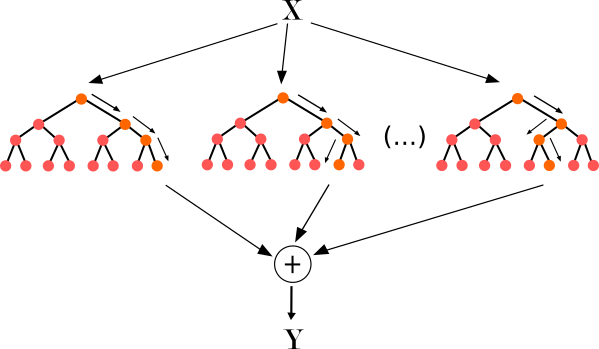

In [12]:
results = evaluate_cores(RandomForestClassifier, df, 250000, stride=10000, printer=True)  # ewaluacja modelu korzytsjącego z algorytmu 
                                                                                          # lasów losowych (random forest)


  n=10000
	  - średni czas uczenia: 0.67 s dla modelu n = model_1 rdzeni
	  - średni czas uczenia: 1.65 s dla modelu n = model_2 rdzeni
	  - średni czas uczenia: 1.59 s dla modelu n = model_3 rdzeni
	  - średni czas uczenia: 1.59 s dla modelu n = model_4 rdzeni

  n=20000
	  - średni czas uczenia: 1.13 s dla modelu n = model_1 rdzeni
	  - średni czas uczenia: 1.60 s dla modelu n = model_2 rdzeni
	  - średni czas uczenia: 1.65 s dla modelu n = model_3 rdzeni
	  - średni czas uczenia: 1.73 s dla modelu n = model_4 rdzeni

  n=30000
	  - średni czas uczenia: 1.89 s dla modelu n = model_1 rdzeni
	  - średni czas uczenia: 2.11 s dla modelu n = model_2 rdzeni
	  - średni czas uczenia: 2.12 s dla modelu n = model_3 rdzeni
	  - średni czas uczenia: 1.82 s dla modelu n = model_4 rdzeni

  n=40000
	  - średni czas uczenia: 2.79 s dla modelu n = model_1 rdzeni
	  - średni czas uczenia: 2.63 s dla modelu n = model_2 rdzeni
	  - średni czas uczenia: 2.63 s dla modelu n = model_3 rdzeni
	  - średni

In [13]:
results.describe()  # wyświetl statystyki podsumowujące wyniki

,model_1,model_2,model_3,model_4,N
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,209.678371,129.667236,106.547971,99.382103,130000.000000
std,137.940534,87.040385,68.940846,67.453565,73598.007219
min,9.468174,11.241198,11.150966,11.190214,10000.000000
25%,87.693963,52.737737,42.084565,36.086469,70000.000000
50%,197.023268,109.845524,104.701128,98.419828,130000.000000
75%,316.397457,198.368373,160.945129,152.508202,190000.000000
max,440.616674,285.719481,225.176878,225.780768,250000.000000


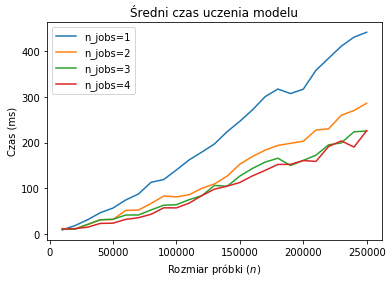

In [14]:
visualize(results, file_n='czas_zbior_2')  # wykres zawierający wyniki eksperymentu